# Second iteration of model - dynamic network

After some interactions a new link is formed between two random agents 

The first to be defined is a state space, here being set to be discrete values. 
Then the Agent class is defined to set an initial state and a method to "consider" it's state options and possibly changing it's state. 

In [13]:
states = [1, -1] #1 being cooperating, 0 being defecting
import random

class Agent:
    def __init__(self, state):
        self.state = state
        self.interactionsReceived = 0
        self.interactionsGiven = 0
    
    def consider(self, neighbour, neighboursWeight):
        self.interactionsReceived +=1
        neighbour.addInteractionGiven()
        weight = self.state*0.8 + politicalClimate + defectorUtility + neighboursWeight*neighbour.state #+ random.uniform(-0.2, 0.2)
        
        #self.state = weight
        if(weight > 0):
            self.state = states[0]
        else:
            self.state = states[1]
    
    def addInteractionGiven(self):
        self.interactionsGiven +=1
        

The model class consists of the agents and includes a method to make these interact. 

In [14]:
from numpy.random import choice
import random
import matplotlib.pyplot as plt
from statistics import stdev, mean
import imageio

class Model:
    def __init__(self):
        #Time dependent topology
        self.graph = nx.Graph()
        self.ratio = []
        self.defectorDefectingNeighsList = []
        self.cooperatorDefectingNeighsList = []
        self.defectorDefectingNeighsSTDList = []
        self.cooperatorDefectingNeighsSTDList =[]
    
    def interact(self):
        nodeIndex = random.randint(0, len(self.graph) - 1)
        node = self.graph.nodes[nodeIndex]['agent']
        
        neighbours =  list(self.graph.adj[nodeIndex].keys())
        
        chosenNeighbourIndex = neighbours[random.randint(0, len(neighbours)-1)]
        chosenNeighbour = self.graph.nodes[chosenNeighbourIndex]['agent']
        
        weight = self.graph[nodeIndex][chosenNeighbourIndex]['weight']
        
        node.consider(chosenNeighbour, weight)
        
    def getAvgNumberOfDefectorNeigh(self):
        defectorFriendsList = []
        defectorNeighboursList = []
        for node in self.graph:
            agreeingNeighbours = 0
            neighbours = list(self.graph.adj[node])
            for neighbourIndex in neighbours:
                if self.graph.nodes[neighbourIndex]['agent'].state == self.graph.nodes[node]['agent'].state:
                    agreeingNeighbours += 1
            if self.graph.nodes[node]['agent'].state== 1:
                defectorNeighboursList.append(agreeingNeighbours/len(neighbours))
            else:
                defectorFriendsList.append(agreeingNeighbours/len(neighbours))
        
        defectoravg = mean(defectorFriendsList)
        cooperatoravg =mean(defectorNeighboursList)
        defectorSTD = stdev(defectorFriendsList)
        cooperatorSTD =stdev(defectorNeighboursList)
        return(defectoravg, cooperatoravg, defectorSTD, cooperatorSTD)
                
    
    def countCooperatorRatio(self):
        count = 0
        for node in self.graph:
            if self.graph.nodes[node]['agent'].state > 0:
                count+=1
        return count/len(self.graph)
 
    def runSim(self, k, drawModel = False, countNeighbours = False, gifname=None):
        
        if(drawModel):
            draw_model(self)
            filenames = []
        
        if(countNeighbours):
            (defectorDefectingNeighs,
             cooperatorDefectingFriends,
             defectorDefectingNeighsSTD,
             cooperatorDefectingFriendsSTD) = self.getAvgNumberOfDefectorNeigh()
            print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
            print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
    
        for i in range(k):
            self.interact()
            self.ratio.append(self.countCooperatorRatio())
            if(countNeighbours):
                (defectorDefectingNeighs,
                 cooperatorDefectingNeighs,
                 defectorDefectingNeighsSTD,
                 cooperatorDefectingNeighsSTD) = self.getAvgNumberOfDefectorNeigh()
                self.defectorDefectingNeighsList.append(defectorDefectingNeighs)
                self.cooperatorDefectingNeighsList.append(cooperatorDefectingNeighs)
                self.defectorDefectingNeighsSTDList.append(defectorDefectingNeighsSTD)
                self.cooperatorDefectingNeighsSTDList.append(cooperatorDefectingNeighsSTD)
            if(drawModel and (i % 10 == 0)):
                draw_model(self, True, i)
                filenames.append("plot" + str(i) +".png")
                
            #if(i % 10 == 0):
                #a = random.randint(0,n)
                #b = random.randint(0,n)
                #while(a==b):
                    #b = random.randint(0,n)
                    #weight = random.uniform(0.1, 0.9)
                    #model.graph.add_edge(a, b, weight = weight)
        if(drawModel):
            images = []
            for filename in filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave("network" +gifname+ ".gif", images, duration=0.04167)
       
    
        if(countNeighbours):
            drawDefectingNeighbours(self.defectorDefectingNeighsList,
                                    self.cooperatorDefectingNeighsList,
                                    self.defectorDefectingNeighsSTDList,
                                    self.cooperatorDefectingNeighsSTDList,
                                    gifname)
        
        return self.ratio

In [15]:
import networkx as nx

def makeGridModel(n):
    model = Model()
    #weight = 0.5
    for i in range(n):
        for j in range (n):
            agent1 = Agent(states[random.randint(0,1)])
            model.graph.add_node(i*n+j, agent=agent1)
            if(i!=0):
                weight = random.uniform(0.1, 0.9)
                model.graph.add_edge(i*n+j, (i-1)*n+j, weight = weight)
            if(j!=0):
                weight = random.uniform(0.1, 0.9)
                model.graph.add_edge(i*n+j, i*n+j-1, weight = weight)
    
    return model

In [16]:
import matplotlib.pyplot as plt
from IPython.display import Image


def draw_model(model, save=False, filenumber = None):

    color_map = []
    for node in model.graph:
        if model.graph.nodes[node]['agent'].state== 1:
            color_map.append('green')
        else: color_map.append('red')   
    
    plt.subplot(121)
    nx.draw_spectral(model.graph, node_color = color_map,)
    if(save):
        plt.savefig("plot" + str(filenumber) +".png", bbox_inches="tight")


In [17]:
import matplotlib.pyplot as plt  
import numpy as np
  
def drawDefectingNeighbours(defectorDefectingNeighsList, cooperatorDefectingNeighsList, defectorDefectingNeighsSTDList, cooperatorDefectingNeighsSTDList, filname = None):
    steps = range(0, len(defectorDefectingNeighsList))
    defector = np.array( defectorDefectingNeighsList)
    defectorSTD = np.array( defectorDefectingNeighsSTDList)
    cooperator = np.array(cooperatorDefectingNeighsList)
    cooperatorSTD = np.array( cooperatorDefectingNeighsSTDList)
    
    # You typically want your plot to be ~1.33x wider than tall.  
    # Common sizes: (10, 7.5) and (12, 9)  
    plt.figure(figsize=(12, 9))  
    
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].set_title('Development of defector neighbours')
  
    # Remove the plot frame lines. They are unnecessary chartjunk.  
    #axarr[0] = plt.subplot(111)  
    #ax.spines["top"].set_visible(False)  
    #ax.spines["right"].set_visible(False)  
   
    #ax.get_xaxis().tick_bottom()  
    #ax.get_yaxis().tick_left()  
   
  
    # Along the same vein, make sure your axis labels are large  
    # enough to be easily read as well. Make them slightly larger  
    # than your axis tick labels so they stand out.  
    plt.ylabel("avg number of defector friends", fontsize=12)  
  
    # Use matplotlib's fill_between() call to create error bars.    
    axarr[0].fill_between(steps, cooperator - cooperatorSTD,  
                 cooperator + cooperatorSTD,  color="#397c39")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[0].plot(steps, cooperatorDefectingNeighsList, color="white", lw=2) 
   
    axarr[1].fill_between(steps, defector - defectorSTD,  
                 defector + defectorSTD,  color="#7c393a")  
  
    # Plot the means as a white line in between the error bars.   
    # White stands out best against the dark blue.  
    axarr[1].plot(steps, defectorDefectingNeighsList, color="white", lw=2) 
    
    #plt.title("Development of defector neighbours", fontsize=22)  
    
  
    # Finally, save the figure as a PNG.  
    # You can also save it as a PDF, JPEG, etc.  
    # Just change the file extension in this call.  
    # bbox_inches="tight" removes all the extra whitespace on the edges of your plot.  
    plt.savefig("avg" + filname +".png", bbox_inches="tight");

In [18]:
def simulate(n, k, **kwargs):
    model = makeGridModel(n)  
    ratio = model.runSim(k, **kwargs)
    return (model, ratio)

In [20]:
def batch_simulate(n,k,s):
    batch_proportions=[]
    politicalClimate = 0.2
    
    for i in range(s):
        (model, proportion) = simulate(n, k)
        batch_proportions.append(proportion)
    return batch_proportions 

## Radial Distribution function
Calculate the number of agreeing nodes per number of jumps out from the node

In [124]:
def radialDist(model, depth, isBefore):
    DefectorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    CooperatorValues = [[0 for i in range(depth)] for j in range(len(model.graph))]
    for nodeIdx in model.graph:
        neighbours = list(model.graph.adj[nodeIdx])
        isCooperator = model.graph.nodes[nodeIdx]['agent'].state > 0
        for d in range(depth):
            nextLevelNeighs = set([])
            for n in neighbours:
                nextLevelNeighs.update(list(model.graph.adj[n]))
                if(model.graph.nodes[n]['agent'].state > 0 and isCooperator):
                    CooperatorValues[nodeIdx][d] += 1
                elif(model.graph.nodes[n]['agent'].state <= 0 and not isCooperator): 
                    DefectorValues[nodeIdx][d] += 1
            CooperatorValues[nodeIdx][d] = CooperatorValues[nodeIdx][d]/len(neighbours)
            DefectorValues[nodeIdx][d] = DefectorValues[nodeIdx][d]/len(neighbours)
            for n in neighbours:
                nextLevelNeighs.discard(n) #May be wrong, might have to build a sep list for "parent level"
            neighbours = nextLevelNeighs
            neighbours.discard(nodeIdx)
     
    cooperatorRatio = model.countCooperatorRatio()
    
    cooperatorRes = []
    defectorRes = []
    for col in range(depth):
        coopSumRatios = 0
        defectSumRatios = 0
        for row in range(len(CooperatorValues)):
            coopSumRatios += CooperatorValues[row][col]
            defectSumRatios += DefectorValues[row][col]
        cooperatorRes.append(np.array(coopSumRatios)/(len(model.graph)*cooperatorRatio*cooperatorRatio))
        defectorRes.append(np.array(defectSumRatios)/(len(model.graph)*(1-cooperatorRatio)*(1-cooperatorRatio)))
    print(cooperatorRes)
    if isBefore:
        intensity = 0.5
    else:
        intensity = 1
    plt.plot(cooperatorRes, color=((23/255, 104/255, 37/255, intensity))) 
    plt.plot(defectorRes, color=((109/255, 10/255, 10/255, intensity))) 

[0.9446366782006922, 0.9773356401384083, 0.9695896231795886, 0.9944630905161527, 0.9889499075054983, 1.0187831460183465, 0.9828431028002209, 1.0172730722537018, 0.9888587916619442, 1.0227614288381184, 0.9839863931389646, 1.0170936514124105]
0.4722222222222222
[1.1093791991400161, 0.9525089261719198, 1.0108177229918698, 0.9926477371386373, 1.0067850172722055, 1.0086699194579258, 1.004324600398924, 1.008067987943153, 1.0084544164485096, 1.0168017438068067, 1.0025154425451042, 1.0083675890774881]
0.4236111111111111


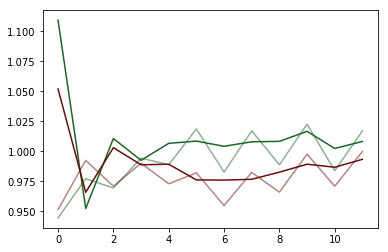

In [130]:
model = makeGridModel(12)
radialDist(model, 12, True)
print(model.countCooperatorRatio())
model.runSim(2000)
radialDist(model, 12, False)
print(model.countCooperatorRatio())


In [64]:
defectorUtility = -0.21 
 
politicalClimate=0.2 #Being environment-positive 

    
#(results) = batch_simulate(12, 1000,100)

#for i in results:
    #plt.plot(i)

c:\users\sigrid\appdata\local\programs\python\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
c:\users\sigrid\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Defectors: avg:  0.5191666666666667  std:  0.23506624985355123
Cooperators: avg:  0.5175  std:  0.28436235445650876


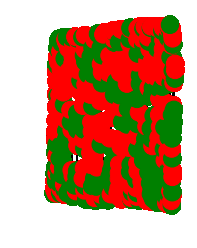

<Figure size 864x648 with 0 Axes>

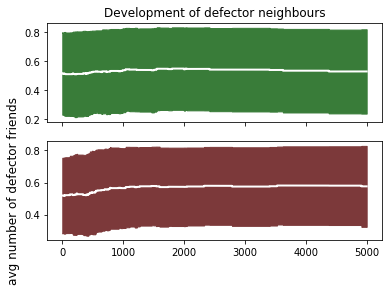

In [114]:
(model, ratio) = simulate(12, 1000, drawModel= False, countNeighbours= False)


{1, 2, 3}
{2, 3}


0.41
Defectors: avg:  0.7372881355932204  std:  0.2728159348725995
Cooperators: avg:  0.3882113821138211  std:  0.312144106286553


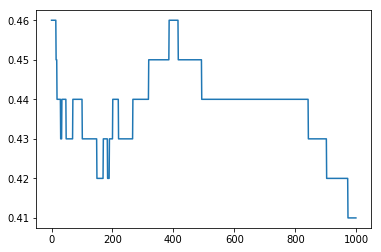

In [40]:
plt.plot(ratio)
print(model.countCooperatorRatio())
(defectorDefectingNeighs, cooperatorDefectingFriends, defectorDefectingNeighsSTD, cooperatorDefectingFriendsSTD)=model.getAvgNumberOfDefectorNeigh()
print("Defectors: avg: ", defectorDefectingNeighs, " std: ", defectorDefectingNeighsSTD)
print("Cooperators: avg: ", cooperatorDefectingFriends, " std: ", cooperatorDefectingFriendsSTD)
        

[1, 12]


ZeroDivisionError: division by zero